# DQN with `dm_control`

Here are some experiments using deep Q-Learning to solve simple continuous control tasks. I implemented [the original DQN](https://www.nature.com/articles/nature14236) and used it to solve several tasks in the [DeepMind Control Suite](https://arxiv.org/abs/1801.00690). The main ideas are:
1. Maintain a replay buffer of experiences that are drawn from for training. This decreases correlations in the training data.
2. Keep an additional Q network used for calculating targets that is updated less frequently that the main Q network. This stabalizes the updates.

Q-Learning takes the max across actions, which is not ideal for continuous action spaces. In this implementation the action space is discretized, such that each action dimension can take a value in `linspace(action_min, actions_max, action_grid)`, where `action_grid` $\in (2,3)$ in this demo. The full action space is the cartesian product of the vectors for each dimension.

The demo is organized as follows:
1. **setup**
2. **solving tasks:** pendulum, cartpole, ball in cup
3. **double DQN:** I implement [Double Q-Learning](https://arxiv.org/abs/1509.06461) and show that it increases the accuracy of action-value estimates.
4. **encouraging exploration:** To increase exploration I used a simple trick to encourage optimism in the face of uncertainty. Namely, I pretrained the network to output optimistic action-values across the state-space, which encourages exploration in the early phases of learning.  

# setup

We start by defining some utility functions that will help with plotting and training. To increase training speed I found it helpful to:
- *Train on the CPU rather than GPU.* The Q network is very small. My CPU was faster than the GPU unless batch sizes were really large.
- *Perform forward passes on Numpy*. Network forward passes ended up being much faster using numpy rather than Tensorflow (again, unless batch sizes were really large).
- *Train multiple agents in parallel*. Training results could be somewhat idiosyncratic even with the same hyperparameters, so I train 12 agents in parallel to make sure the results are robust.

In [57]:
#@title setup

%load_ext autoreload
%autoreload 2

from concurrent.futures import ProcessPoolExecutor
from dm_control_tests.agents import Agent
from dm_control_tests import train_utils, plot_utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dm_control import suite
from itertools import repeat
import tensorflow as tf
import numpy as np
import pickle
import shutil
import os


tf.get_logger().setLevel('ERROR')
train_utils.disable_gpu()

# plot performance over training, averaged across agents
def plot_performance(x, data):
    ax = plt.axes(xlabel='episode', ylabel='return',
                  xlim=(x[0],x[-1]), ylim=(0,1000))
    data = np.array(data)
    mean = data.mean(0)
    std = data.std(0)
    ax.plot(x, data.T, color=(0,0,0), alpha=.15)
    ax.plot(x, mean)
    ax.fill_between(x, mean+std, mean-std, alpha=.15)

# train multiple agents in parallel on a particular domain and task
def train_agents_parallel(domain_and_task, agent_args, train_args,
                         optimistic_q=None, n_agents=12, n_workers=12, save_dir=None, overwrite=False):
    
    if save_dir is not None:
        if overwrite and os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        os.mkdir(save_dir)
        paths = ['{}/agent{:03d}'.format(save_dir, i) for i in range(n_agents)]
    else:
        repeat(None, n_agents)
    
    with ProcessPoolExecutor(max_workers=n_workers) as executor:    
        results = executor.map(train_utils.create_and_train_agent, 
                               repeat(domain_and_task, n_agents),
                               repeat(agent_args),
                               repeat(train_args),
                               repeat(optimistic_q),
                               paths,
                               [True]+list(repeat(False, n_agents-1)))  # only verbose for first thread
        results = [r for r in results]
    episode_num = results[0][0]
    avg_returns = np.array([np.array(r[1]).mean(1) for r in results])
    
    if save_dir is not None:
        training_data = {'episode_num': episode_num, 'avg_returns': avg_returns}
        with open(os.path.join(save_dir, 'training_data'), 'wb') as file:
            pickle.dump(training_data, file)
    
    return episode_num, avg_returns

# show a rollout for the agent with the best performance at the end of training
def show_best_agent_rollout(agents_dir, framerate=30):
    with open(os.path.join(agents_dir, 'training_data'), 'rb') as file:
        training_data = pickle.load(file)
    best_agent = np.argmax(training_data['avg_returns'][:,-1])
    agent, metadata = train_utils.load_agent(
        os.path.join(agents_dir, 'agent{:03d}'.format(best_agent)))
    env = suite.load(*metadata['domain_and_task'])
    return plot_utils.show_rollout_jupyter(agent, env, epsilon=.05, framerate=framerate)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### training
Let's set up the hyperparameters for training. Every action dimension will be discretized into `action_grid=2` actions. This makes training fast, but it also means a given action can't be set to `0`. We will use a replay buffer of size `buffer_length=50000` that is initialized using random actions prior to training and a Q network with hidden layers of size `units_per_layer=(12,24)`.  The target Q network will be updated after every `q_update_interval=100` updates of the main Q network.

The temporal resolution of the `dm_control` environments is rather high. During exploration, especially with sparse rewards, the sequence of correctly chosen actions necessary to discover the reward may be quite long. Therefore (as in the original paper), I repeat each action `action_repeats=2` times. Furthermore, I only perform network updates every `steps_per_update=4` iterations. The updates, rather than the physics simulations, are the speed bottleneck. This allows the agent to see more episodes with the same number of updates.

I train for `episodes=200` episodes with `batch_size=64`, acting $\epsilon$-greedy with $\epsilon$ linearly annealed from `epsilon_start=1` to `epsilon_final=.1` over `epsilon_final_episode=100` episodes.

### evaluation
Finally, every `eval_interval = 10` episodes I estimate the return by averaging the return from 5 rollouts with $\epsilon = .05$. $12$ agents are trained in parallel, and I plot the average += standard deviation of the return across these agents.

In [170]:
# @title hyperparameters 

# agent
agent_args = dict(
    action_grid = 2,            # number of discrete actions per action dimension
    units_per_layer = (12,24),  # hidden units per layer
    buffer_length = 50000,
    q_update_interval = 100,    # q updates per q_target update
    learning_rate = .001,       # learning rate (adam optimizer)       
)

# training
train_args = dict(
    episodes = 200,
    eval_interval = 10,
    batch_size = 64,
    action_repeats = 2,         # repeat each action this number of times during training
    steps_per_update = 4,       # environment steps before updating q
    gamma = .99,
    epsilon_start = 1,
    epsilon_final = .1,
    epsilon_final_episode = 100,   # episode at which epsilon_final is reached
)

# solving simple tasks
will solve pendulum, swing up, and ball in cup

## pendulum

In [ ]:
env = suite.load('pendulum', 'swingup', task_kwargs={'random': 0})
train_utils.rand_seed_reset(env, 0)
agent = Agent(env.observation_spec(), env.action_spec(), **agent_args)
train_utils.initialize_buffer(agent, env, verbose=False)


# create state space grid points
bins = 40
angle_lims = (-np.pi/2, np.pi/2)
vel_lims = (-10,10)
axis_grids = [np.linspace(lims[0], lims[1], num=bins) for lims in (angle_lims, vel_lims)]
grid = np.array(np.meshgrid(*axis_grids)).reshape(2, -1).T
grid_predict = np.vstack((np.cos(grid[:,0]), np.sin(grid[:,0]), grid[:,1])).T  # first two columns are cos(x), sin(x) instead of x

def compute_prediction_grid(agent, env):
    q_map = agent.q.predict(grid_predict).reshape(bins, bins, 2)
    return q_map

episode_num, returns, q_maps = train_utils.train(
    agent, env, **train_args, verbose=True, callback=compute_prediction_grid)
returns = [np.mean(r) for r in returns]

plt.plot(episode_num, returns);


training agent...


iteration   10, avg return  0.0
iteration   20, avg return  0.0
iteration   30, avg return 11.6
iteration   40, avg return  0.0


In [184]:
preference_maps = [m[:,:,0] - m[:,:,1] for m in q_maps]
abs_max = np.abs(np.array(preference_maps)).max()
plot_utils.display_video(
    preference_maps, framerate=5, scaling=20, is_plot=True,
    imshow_args={'extent': angle_lims+vel_lims, 'cmap': 'bwr',
                 'vmin': -abs_max, 'vmax': abs_max})

In [203]:
plot_utils.show_rollout_jupyter(agent, env)


## cartpole (balance)

- state space only r2 and action space r1 - try this out to make sure everything is in order
- explain evaluation metrics... evaluated every n eps, avg of m eps with z epsilon

training agent...


iteration   10, avg return 239.2
iteration   20, avg return 268.6
iteration   30, avg return 369.5
iteration   40, avg return 597.4
iteration   50, avg return 449.8
iteration   60, avg return 531.1
iteration   70, avg return 431.3
iteration   80, avg return 484.9
iteration   90, avg return 680.3
iteration  100, avg return 631.8
iteration  110, avg return 625.7
iteration  120, avg return 634.8
iteration  130, avg return 632.1
iteration  140, avg return 605.4
iteration  150, avg return 798.3
iteration  160, avg return 698.8
iteration  170, avg return 659.7
iteration  180, avg return 695.2
iteration  190, avg return 717.6
iteration  200, avg return 729.4



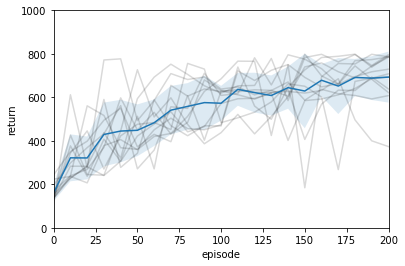

In [15]:
episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'balance'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_balance', overwrite=True)
plot_performance(episode_num, avg_returns)

In [25]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_balance')

## cartpole (swingup)

training agent...


iteration   10, avg return 112.0
iteration   20, avg return 182.1
iteration   30, avg return 140.3
iteration   40, avg return 127.7
iteration   50, avg return 126.4
iteration   60, avg return 305.2
iteration   70, avg return 618.0
iteration   80, avg return 523.8
iteration   90, avg return 500.5
iteration  100, avg return 425.3
iteration  110, avg return 469.0
iteration  120, avg return 284.5
iteration  130, avg return 136.4
iteration  140, avg return 559.2
iteration  150, avg return 433.9
iteration  160, avg return 424.3
iteration  170, avg return 242.1
iteration  180, avg return 530.5
iteration  190, avg return 430.7
iteration  200, avg return 570.9



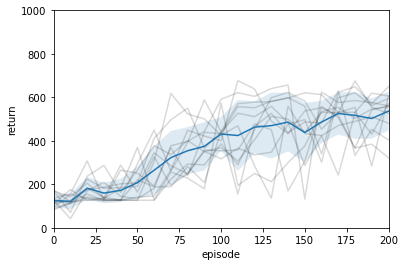

In [4]:
episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_swingup', overwrite=True)
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout('dm_control_tests/agents/cartpole_swingup')

## ball in cup

training agent...


iteration   10, avg return 204.6
iteration   20, avg return 563.6
iteration   30, avg return 219.0
iteration   40, avg return 227.0
iteration   50, avg return 32.6
iteration   60, avg return 42.6
iteration   70, avg return  0.0
iteration   80, avg return 378.2
iteration   90, avg return 296.4
iteration  100, avg return 430.0
iteration  110, avg return 489.6
iteration  120, avg return 435.6
iteration  130, avg return 573.2
iteration  140, avg return 535.0
iteration  150, avg return 815.8
iteration  160, avg return 534.2
iteration  170, avg return 283.4
iteration  180, avg return 490.8
iteration  190, avg return 623.2
iteration  200, avg return 508.4



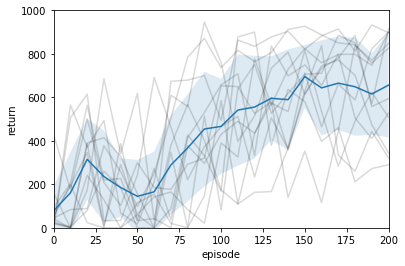

In [3]:
episode_num, avg_returns = train_agents_parallel(
    ('ball_in_cup', 'catch'), agent_args, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/ball_in_cup', overwrite=True)
plot_performance(episode_num, avg_returns)

In [5]:
show_best_agent_rollout('dm_control_tests/agents/ball_in_cup')

# double q learning
max operation leads to overly optimistic q values // double q have two q functions learned on dft data samples // dqn doesn't go this far, but uses it's two q functions for action selection and evaluation... increases accuracy of q estimates, as shown in pendulum...

training agent...


iteration   10, avg return 144.7
iteration   20, avg return 232.3
iteration   30, avg return 240.4
iteration   40, avg return 203.8
iteration   50, avg return 343.9
iteration   60, avg return 478.6
iteration   70, avg return 172.0
iteration   80, avg return 367.2
iteration   90, avg return 368.6
iteration  100, avg return 416.1
iteration  110, avg return 575.7
iteration  120, avg return 600.0
iteration  130, avg return 499.0
iteration  140, avg return 603.0
iteration  150, avg return 583.6
iteration  160, avg return 620.8
iteration  170, avg return 494.6
iteration  180, avg return 608.0
iteration  190, avg return 588.8
iteration  200, avg return 668.7



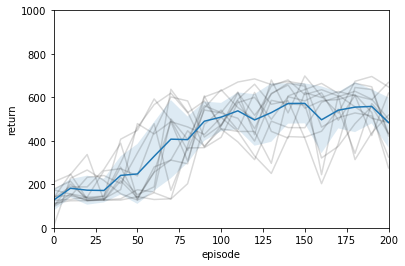

In [4]:
agent_args_dq = agent_args
agent_args_dq['double_dqn'] = True

episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args_dq, train_args, n_agents=12, n_workers=12,
    save_dir='dm_control_tests/agents/cartpole_swingup_dq', overwrite=True)
plot_performance(episode_num, avg_returns)

In [ ]:
# todo: compare accuracy for dqn and double dqn

# optimistic initializations
for sparse reward agent needs to accidentally discover correct action sequence // can be very hard when that sequence is long // initializing optimisitic values of q can hopefully encourage initial exploration and speed up learning...

In [ ]:
episode_num, avg_returns, weights = train_agents_parallel(('cartpole', 'swingup'),
    agent_args, train_args, n_agents=12, n_workers=12, optimistic_q=100)
plot_performance(episode_num, avg_returns)

# sandbox...

In [3]:
# train and save models in parallel
test_path='dm_control_tests/models/parallel_test'
train_args_temp = train_args
train_args_temp['episodes'] = 2

episode_num, avg_returns = train_agents_parallel(
    ('cartpole', 'swingup'), agent_args, train_args_temp, n_agents=12, n_workers=12,
    save_dir=test_path, overwrite=True)

overwriting dm_control_tests/models/parallel_test
training agent...


In [6]:
# load saved agent
agent = train_utils.load_agent(os.path.join(test_path, 'agent000'))[0]
agent.q.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________
